# Exercise 2: Binary Classification with Synthetic Data and Scratch MLP

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

In [12]:
def sample_class_from_make_classification(
    target_label: int,
    n_desired: int,
    n_clusters_per_class: int,
    random_state: int,
    class_sep: float = 1.5,
):
    rng = np.random.RandomState(random_state)
    X_list, y_list = [], []
    total_collected = 0
    batch = max(1000, n_desired * 2)
    
    while total_collected < n_desired:
        # Make a batch (balanced by default). We then filter for the target label.
        Xb, yb = make_classification(
            n_samples=batch,
            n_features=2,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=n_clusters_per_class,
            class_sep=class_sep,
            flip_y=0.0,
            random_state=rng.randint(0, 10_000_000),
        )
        mask = (yb == target_label)
        X_keep = Xb[mask]
        y_keep = yb[mask]
        needed = n_desired - total_collected
        if X_keep.shape[0] > needed:
            X_keep = X_keep[:needed]
            y_keep = y_keep[:needed]
        X_list.append(X_keep)
        y_list.append(y_keep)
        total_collected += X_keep.shape[0]
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

In [13]:
X0, y0 = sample_class_from_make_classification(
    target_label=0, n_desired=500, n_clusters_per_class=1, random_state=42, class_sep=1.6
)
X1, y1 = sample_class_from_make_classification(
    target_label=1, n_desired=500, n_clusters_per_class=2, random_state=1337, class_sep=1.6
)
# Relabel to 0 and 1
y0[:] = 0
y1[:] = 1

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1]).astype(np.float64)

# Shuffle
rs = np.random.RandomState(2025)
perm = rs.permutation(len(y))
X = X[perm]
y = y[perm]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7, stratify=y
)

In [14]:
# Scratch MLP implementation
class ScratchMLP:
    def __init__(self, input_dim=2, hidden_dim=8, lr=0.05, seed=0):
        rng = np.random.RandomState(seed)
        # Xavier/Glorot initialization for tanh/sigmoid
        limit1 = np.sqrt(6 / (input_dim + hidden_dim))
        self.W1 = rng.uniform(-limit1, limit1, size=(input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))
        limit2 = np.sqrt(6 / (hidden_dim + 1))
        self.W2 = rng.uniform(-limit2, limit2, size=(hidden_dim, 1))
        self.b2 = np.zeros((1, 1))
        self.lr = lr

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_deriv(a):
        # a is tanh(z). derivative = 1 - a^2
        return 1.0 - a ** 2

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def bce_loss(y_true, y_prob, eps=1e-12):
        y_prob = np.clip(y_prob, eps, 1 - eps)
        return np.mean(-(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1         # (N, H)
        a1 = self.tanh(z1)                 # (N, H)
        z2 = a1 @ self.W2 + self.b2        # (N, 1)
        yhat = self.sigmoid(z2)            # (N, 1)
        cache = (X, z1, a1, z2, yhat)
        return yhat, cache

    def backward(self, cache, y_true):
        X, z1, a1, z2, yhat = cache
        N = X.shape[0]
        y_true = y_true.reshape(-1, 1)

        # dL/dz2 for BCE + sigmoid: (yhat - y)/N
        dz2 = (yhat - y_true) / N                  # (N,1)
        dW2 = a1.T @ dz2                           # (H,1)
        db2 = np.sum(dz2, axis=0, keepdims=True)   # (1,1)

        da1 = dz2 @ self.W2.T                      # (N,H)
        dz1 = da1 * self.tanh_deriv(a1)            # (N,H)
        dW1 = X.T @ dz1                            # (D,H)
        db1 = np.sum(dz1, axis=0, keepdims=True)   # (1,H)

        grads = (dW1, db1, dW2, db2)
        return grads

    def step(self, grads):
        dW1, db1, dW2, db2 = grads
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, y, epochs=300, verbose=False):
        history = []
        for ep in range(epochs):
            yhat, cache = self.forward(X)
            loss = self.bce_loss(y.reshape(-1, 1), yhat)
            history.append(loss)
            grads = self.backward(cache, y)
            self.step(grads)
            if verbose and (ep+1) % 50 == 0:
                print(f"Epoch {ep+1:4d} | Loss: {loss:.6f}")
        return history

    def predict_proba(self, X):
        yhat, _ = self.forward(X)
        return yhat.ravel()

    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int)

In [15]:
# Train the model
mlp = ScratchMLP(input_dim=2, hidden_dim=10, lr=0.05, seed=123)
history = mlp.fit(X_train, y_train, epochs=300, verbose=True)

Epoch   50 | Loss: 0.532952
Epoch  100 | Loss: 0.499184
Epoch  150 | Loss: 0.485330
Epoch  200 | Loss: 0.477413
Epoch  250 | Loss: 0.471983
Epoch  300 | Loss: 0.467827


In [16]:
# Evaluate
y_proba_test = mlp.predict_proba(X_test)
y_pred_test = (y_proba_test >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

print(f"Test accuracy: {acc:.4f}")
print("Confusion matrix:")
print(cm)

Test accuracy: 0.7350
Confusion matrix:
[[100   0]
 [ 53  47]]


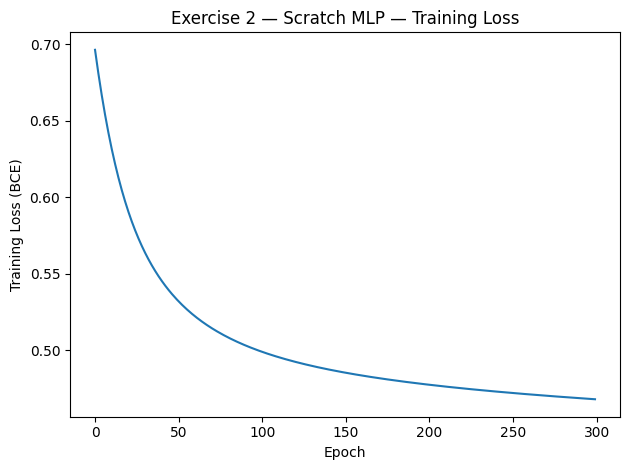

In [17]:
plt.figure()
plt.plot(np.arange(len(history)), history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (BCE)")
plt.title("Exercise 2 — Scratch MLP — Training Loss")
plt.tight_layout()
plt.show()

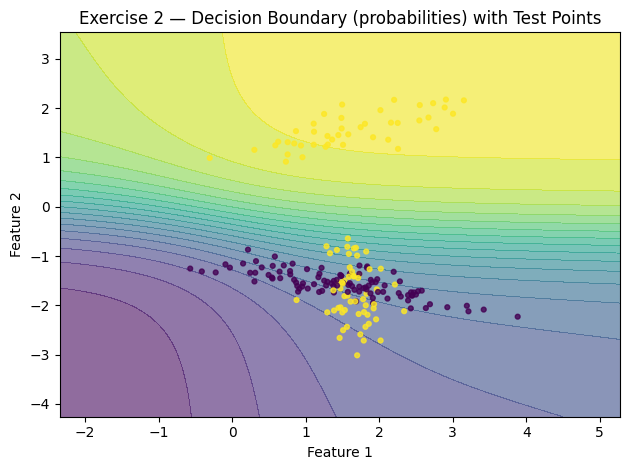

In [18]:
x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = mlp.predict_proba(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, probs, levels=20, alpha=0.6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=12, alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Exercise 2 — Decision Boundary (probabilities) with Test Points")
plt.tight_layout()
plt.show()

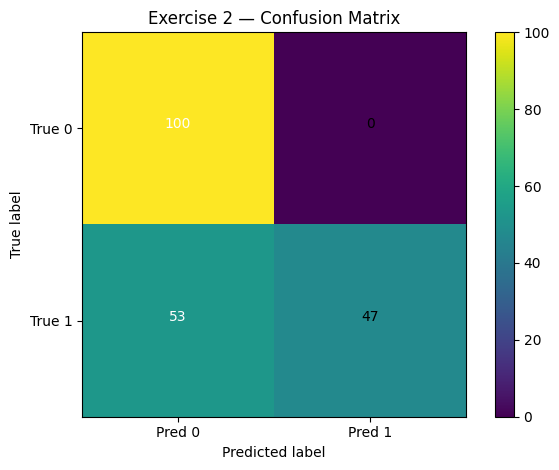

In [19]:
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Exercise 2 — Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred 0','Pred 1'])
plt.yticks(tick_marks, ['True 0','True 1'])

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()